In [1]:
"""Converts data & definies 2D plotting"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from scipy import optimize

def preparedataset(df):
    wav = np.array(df[df.columns[0]])[1:]
    df = df.drop(df.columns[0], axis=1)
    t = np.array(df)[0,:]
    z = np.transpose(np.array(df)[1:,:])
    return wav, t, z
    
def contplot(x,y,z, ylimits, ncontours):
    plt.contourf(x, y, z.transpose(), ncontours, cmap='nipy_spectral')
    plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
    plt.ylim(ylimits)
    plt.colorbar()
    plt.savefig('test.png', dpi=300)
    plt.show()
    return

In [2]:
"""Normalization"""

def normalize(z):
    for i in range(len(z)):
        z[i] = z[i]/np.max(z[i])
    return z

In [3]:
"""INTERPOLATION: (t can't have duplicates)"""

def interpolatedtime(tmin, tmax, step):
    npoints = round((tmax-tmin)/step)+1
    """need the plus one to get uniform 1ns spacing"""
    return np.linspace(tmin, tmax, npoints)

def interpolatedz(wav, t, z):
    t_interp = interpolatedtime(0, 20e-6, 1e-9)
    t_unique, t_unique_ind = np.unique(t, return_index=True)

    z_unique = []
    for i in range(len(t_unique_ind)):
        dec_unique = z[t_unique_ind[i]]
        z_unique = np.concatenate((z_unique, dec_unique))
    z_unique = np.reshape(z_unique, (len(t_unique),len(wav)))

    z_interp = []
    for i in range(len(wav)):
        dec_interp = interpolate.griddata(t_unique, z_unique[:,i], t_interp, method='linear')
        z_interp = np.concatenate((z_interp, dec_interp))
    z_interp = np.reshape(z_interp, (len(wav),len(t_interp)))

    return t_interp, z_interp

In [4]:
"""t0 CORRECTION:"""

def t0find(wav,t,z):
    t0list = []
    t0poslist = []
    for i in range(len(z)):
        pos = np.argmax(z[i])
        t0 = t[pos]
        t0list.append(t0)
        t0poslist.append(pos)
    return t0list, t0poslist

def t0corr(wav, t_interp, z_interp):
    t0listzinterp, t0poslistint = t0find(wav, t_interp, z_interp)

    origlendec = np.shape(z_interp)[1]
    latestt0pos = np.max(t0poslistint)
    latestt0 = np.max(t0listzinterp)

    z_corr = []
    for i in range(len(wav)): 
        dec = z_interp[i,:]
        offset = latestt0pos - np.argmax(dec)
        dec_corr = dec[:(origlendec - offset)]
        dec_corr = np.concatenate((np.zeros(offset), dec_corr))
        z_corr = np.concatenate((z_corr, dec_corr))

    t_corr = t_interp[0:origlendec]
    t_corr = t_corr - latestt0
    z_corr = np.reshape(z_corr, (len(wav),len(t_corr)))
    return t_corr, z_corr

In [5]:
"""Spectra"""

def t_to_n(t, t_list):
    step = t[1]-t[0]
    n_list = []
    for i in range(len(t_list)):
        n = int(round((t_list[i] - np.min(t))/step))
        n_list = np.append(n_list, n)
    return n_list

def spectrum(wav, t, z, t_list):
    mask = np.zeros_like(z, dtype=bool)
    mask[11:12] = True
    z = np.ma.array(z, mask=mask)

    nlist = t_to_n(t, t_list)
    
    for i in range(len(nlist)):
        n = int(nlist[i])
        plt.plot(wav, z[:,n], '.-', label=('t ='+'{:0.1e}'.format(t[n])))
        
    #plt.xlim(4.5,5)
    plt.legend()
    plt.show()
    return

In [6]:
"""Raw Kinetics"""

def kintrace(wav, t, z, w_list):
    for i in range(len(w_list)):
        n = int((np.where(wav==w_list[i]))[0])
        plt.plot(t, z[n,:], '-', label=(str(w_list[i])))
        #plt.yscale('log')
       # plt.ylim(1e-3,1)
        plt.xlim(-1e-6,10e-6)
    plt.legend()
    plt.show()
    return

In [7]:
"Kinetic Fits"

def monoexp(x, *param):
    if len(param) == 1:
        param = param[0]  ## weird extra array correction after popt returns and try to run for fitted 
    a1, t1 = param[0], param[1]
    return a1 * np.exp(-x/t1)
        
def biexp(x, *param):
    if len(param) == 1:
        param = param[0]  ## weird extra array correction after popt returns and try to run for fitted 
    a1, t1, a2, t2 = param[0], param[1], param[2], param[3]
    return a1 * np.exp(-x/t1) + a2 * np.exp(-x/t2)

def proc_trace(x, y, func, param, plot_bool=False):
    popt, pconv = optimize.curve_fit(f=func,xdata=x,ydata=y,p0=param)
    fitted = func(x,popt)
    if plot_bool == True:
        plt.plot(x,y,x,fitted)
        plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        plt.show()
    return popt

def kinfitall(wav, t, z, param, plot_bool):
    
    "after t0corr, delete everything before t=0"
    t0index = int((np.where(t==0))[0])
    t_pos = t[t0index:]
    z_pos = z[:,t0index:]

    if len(param)==2:
        func = monoexp
    if len(param)==4:
        func = biexp
    
    poptlist = []
    for i in range(len(wav)):
        popt_i = proc_trace(t_pos, z_pos[i,:], func, param, plot_bool)
        poptlist = np.concatenate((poptlist, popt_i))
    poptlist = np.reshape(poptlist, (len(wav), len(param)))
    return poptlist

In [8]:
#df = pd.read_csv('C:/pythonall/data/180715.anatase.mdw.6_dataset.csv', header=None)
#df = pd.read_excel('C:/pythonall/data/180710.mulltidelwav.1.xlsx', header=None)
#df = pd.read_excel('C:/pythonall/data/180713.ge.mdwtest.2.xlsx', header=None)
df = pd.read_excel('C:/pythonall/data/180712.anatase.mdw.2.xlsx', header=None)
#df = pd.read_excel('Data/180715.anatase.mdw.5.xlsx', header=None)

"""pandas doesn't allow duplicate headers: would append .1 after time; use: header=None"""

#df = df.drop([1,2,3,4,5,6,7,8,9,10,11,12,13]) ## remove dodgy wavelengths - KEEP 0th!!!
#df = df.drop([25])

wav, t, z = preparedataset(df)

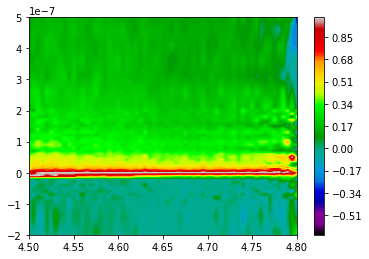

In [9]:
t_interp, z_interp = interpolatedz(wav, t, z)
z_interp = normalize(z_interp)

t_interp_shifted = t_interp-1.99e-6
contplot(wav,t_interp_shifted,z_interp, (-2e-7, 5e-7), 200)

#tshifted = t - 2e-6
#contplot(wav,tshifted,z.transpose(), (-1e-7, 1e-7), 200)

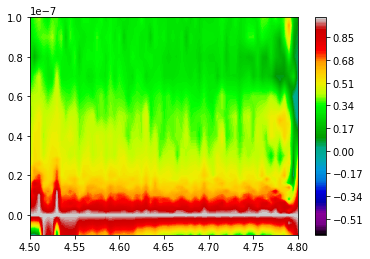

In [10]:
t_corr, z_corr = t0corr(wav, t_interp, z_interp)

contplot(wav,t_corr,z_corr, (-0.1e-7, 0.1e-6), 200)

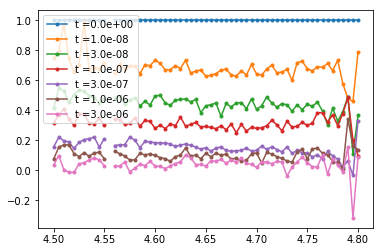

In [11]:
#timelist = np.linspace(0,2e-7,5)
timelist = (0, 1e-8, 3e-8, 1e-7, 3e-7, 1e-6, 3e-6)
spectrum(wav, t_corr, z_corr, timelist)
#spectrum(wav, t_interp1, z_interp, timelist)

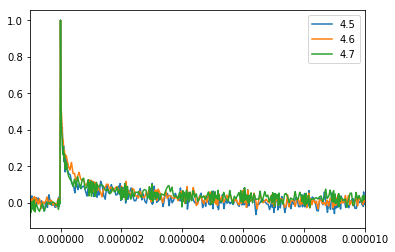

In [12]:
#kinwavlist = (5.45, 5.8, 5.95, 6.15, 6.4, 6.9)
kinwavlist = (4.5,4.6,4.7)
kintrace(wav,t_corr,z_corr,kinwavlist)

In [13]:
#poptlist = kinfitall(wav, t_corr, z_corr, param=(0.03, 1e-7
poptlist = kinfitall(wav, t_corr, z_corr, param=(1, 1e-7
                                               , 0.01, 10e-6
                                                ), plot_bool=False)

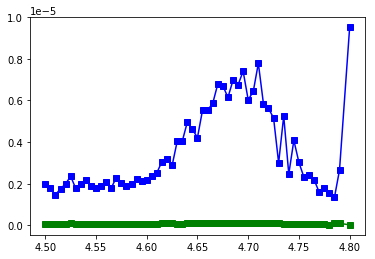

In [14]:
wav2 = np.delete(wav,(-2))
poptlist2 = np.delete(poptlist,(-2),axis=0)

t1l = poptlist2[:,1]
t2l = poptlist2[:,3]

plt.plot(wav2, t1l, 's-g', 
      wav2, t2l,'s-b'
        )
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#plt.ylim(0,0.7e-5)
plt.show()

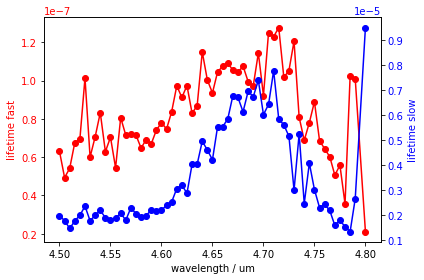

In [33]:
fig, ax1 = plt.subplots()

color = 'r'
ax1.set_xlabel('wavelength / um')
ax1.set_ylabel('lifetime fast', color=color)
ax1.plot(wav2, t1l, color=color, marker='o')
ax1.tick_params(axis='y', labelcolor=color)
#ax1.set_ylim(0,480)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'b'
ax2.set_ylabel('lifetime slow', color=color)  # we already handled the x-label with ax1
ax2.plot(wav2, t2l, color=color, marker='o')
ax2.tick_params(axis='y', labelcolor=color)
ax2.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
#ax2.set_ylim(0,2.3)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.savefig('test')

plt.show()

In [20]:
outfit = pd.DataFrame(data=poptlist2, index=wav2, columns=('a', 't1', 'b', 't2'))
outfit.to_csv('testdf.csv')

In [21]:
inout = pd.read_csv('testdf.csv', index_col=0)
print(inout.index.tolist())

[4.5, 4.505, 4.51, 4.515, 4.52, 4.525, 4.53, 4.535, 4.54, 4.545, 4.55, 4.555, 4.56, 4.565, 4.57, 4.575, 4.58, 4.585, 4.59, 4.595, 4.6, 4.605, 4.61, 4.615, 4.62, 4.625, 4.63, 4.635, 4.64, 4.645, 4.65, 4.655, 4.66, 4.665, 4.67, 4.675, 4.68, 4.685, 4.69, 4.695, 4.7, 4.705, 4.71, 4.715, 4.72, 4.725, 4.73, 4.735, 4.74, 4.745, 4.75, 4.755, 4.76, 4.765, 4.77, 4.775, 4.78, 4.785, 4.79, 4.8]


In [35]:
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.plotly as py
import plotly.tools as tls
#tls.set_credentials_file(username='sebgorgon', api_key='UHqzaU9yUisizpzznjuX')
import plotly.graph_objs as go
plot([go.Scatter(x=[1, 2, 3], y=[3, 1, 6])])
init_notebook_mode(connected=True)